# Import libraries 



In [1]:
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
from pathlib import Path
from crysnet.data import Dataset
from crysnet.data.generator import GraphGenerator
from crysnet.models import GNN
import os
from pymatgen.core.structure import Structure
from crysnet.models import GNN
from crysnet.models.gnnmodel import (
    MpnnBaseModel, TransformerBaseModel , DirectionalMpnnModel, 
    DirectionalTransformerModel, MpnnModel, TransformerModel, 
    GraphModel, CgcnnModel, GraphAttentionModel
)
from keras.models import Model
from keras import layers
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from crysnet.layers import MessagePassing
from crysnet.layers import PartitionPadding
from crysnet.layers import EdgeMessagePassing
import pandas as pd
import numpy as np
import re
import os
from pymatgen.core.structure import Structure
from crysnet.data import Dataset

# Read the Csv file 

In [3]:
df = pd.read_csv('/content/unit_cell_catalog2000.csv')

Save the properties(a,b,c,alpha,beta,gamma) in prop_df and we will get back to that in the training

In [4]:
prop_df = df.iloc[: , 2:8]
prop_df

a        b        c  alpha  beta  gamma
0     1.00000  1.00000  1.00000     90  90.0     90
1     0.85075  0.57449  1.00000     90  90.0     90
2     1.00000  1.00000  1.00000     90  90.0     90
3     0.99471  0.99471  1.00000     90  90.0    120
4     0.50300  0.50300  1.00000     90  90.0     90
...       ...      ...      ...    ...   ...    ...
1995  0.68452  1.00000  0.34059     90  90.0     90
1996  0.99994  1.00000  0.80392     90  90.2     90
1997  0.38120  0.44449  1.00000     90  90.0     90
1998  0.22690  0.22690  1.00000     90  90.0     90
1999  1.00000  0.97372  0.72121     90  99.4     90

[2000 rows x 6 columns]

Same here to the output : Save the output(cx,cy,cz,nx,ny,nz) in y  

In [5]:
y = df.iloc[: , 21:27]
y

Cx    Cy    Cz    nx    ny    nz
0     0.33  0.33  0.33  1.00  1.00  1.00
1     0.23  0.03  0.26  1.01  1.01  1.00
2     0.09  0.09  0.09  2.00  2.00  2.00
3     0.25  0.25  0.25  1.00  1.00  1.00
4     0.25  0.25  0.50  1.00  1.00  1.00
...    ...   ...   ...   ...   ...   ...
1995  0.41  0.16  0.25  1.22  1.83  1.05
1996  0.15  0.15  0.28  1.99  1.98  1.04
1997  0.24  0.13  0.09  1.01  1.01  1.01
1998  0.01  0.01  0.26  1.05  1.05  1.00
1999  0.13  0.12  0.36  2.00  2.00  1.35

[2000 rows x 6 columns]

# Now we want to calculate the distace between atoms (nodes) and calclute the angle using (I,M,N)

first let's explore the data

In [6]:
df.iloc[0 , 30:50]

Bar_ncol                12
nodal_positions_1_1    0.0
nodal_positions_1_2    0.0
nodal_positions_1_3    0.0
nodal_positions_2_1    0.0
nodal_positions_2_2    1.0
nodal_positions_2_3    0.0
nodal_positions_3_1    1.0
nodal_positions_3_2    0.0
nodal_positions_3_3    0.0
nodal_positions_4_1    1.0
nodal_positions_4_2    1.0
nodal_positions_4_3    0.0
nodal_positions_5_1    0.0
nodal_positions_5_2    0.0
nodal_positions_5_3    1.0
nodal_positions_6_1    0.0
nodal_positions_6_2    1.0
nodal_positions_6_3    1.0
nodal_positions_7_1    1.0
Name: 0, dtype: object

In [7]:
df.iloc[0 , 313:350]

bar_connectivity_1_1       1
bar_connectivity_1_2       5
bar_connectivity_2_1       1
bar_connectivity_2_2       2
bar_connectivity_3_1       1
bar_connectivity_3_2       3
bar_connectivity_4_1       2
bar_connectivity_4_2       6
bar_connectivity_5_1       2
bar_connectivity_5_2       4
bar_connectivity_6_1       3
bar_connectivity_6_2       7
bar_connectivity_7_1       3
bar_connectivity_7_2       4
bar_connectivity_8_1       4
bar_connectivity_8_2       8
bar_connectivity_9_1     5.0
bar_connectivity_9_2     6.0
bar_connectivity_10_1    5.0
bar_connectivity_10_2    7.0
bar_connectivity_11_1    6.0
bar_connectivity_11_2    8.0
bar_connectivity_12_1    7.0
bar_connectivity_12_2    8.0
bar_connectivity_13_1    NaN
bar_connectivity_13_2    NaN
bar_connectivity_14_1    NaN
bar_connectivity_14_2    NaN
bar_connectivity_15_1    NaN
bar_connectivity_15_2    NaN
bar_connectivity_16_1    NaN
bar_connectivity_16_2    NaN
bar_connectivity_17_1    NaN
bar_connectivity_17_2    NaN
bar_connectivi

we collect all nodes ID, we have connection between every two atoms so we will collect the ids for the first one in first_nod_lis, and the second one in sec_nod_lis

In [8]:
first_nod_lis = []

for j in range(df.shape[0]):
  first_nod_lis_row = []
  for i in range (313,df.shape[1],2):
    x_nod=df.iloc[j , i]
    first_nod_lis_row.append(x_nod)
  first_nod_lis.append(first_nod_lis_row)
first_nod_lis=np.array(first_nod_lis, ndmin=1)
print((first_nod_lis[1877]))

[ 1.  7.  9.  5.  3.  3.  2. 10. 11. 13.  8. 11.  4. 14.  1.  6.  9. 10.
  2.  5. 12. 11.  1.  7.  3. 10. 13. 11. 15.  1.  2.  1.  3.  1.  4. 23.
  3.  2.  3.  2.  4.  4.  7. 32.  7.  5.  6.  5.  6.  6.  8.  6.  9.  1.
 12.  9.  1.  7.  9.  2. 10. 12.  5. 11.  2.  9.  2.  5.  5.  6. 12. 12.
  4. 11. 11. 15. 15. 16. 16.  8.  8. 14. 14. 14.  3.  6. 13.  4. 15. 16.
  8. 14.  5. 12. 12.  4. 11. 15.  8.  8. 14. 91. 93.]


In [9]:
sec_nod_lis = []

for j in range(df.shape[0]):
  sec_nod_lis_row = []
  for i in range (314,df.shape[1],2):
    x_nod=df.iloc[j , i]
    sec_nod_lis_row.append(x_nod)
  sec_nod_lis.append(sec_nod_lis_row)
sec_nod_lis=np.array(sec_nod_lis, ndmin=1)
print((sec_nod_lis[1877]))

[ 7. 13. 10.  9. 10.  6. 10. 16. 13. 15. 13. 12. 15. 16.  3.  7. 13. 15.
  4.  8. 16. 14. 10.  9.  7. 13. 14. 16. 16. 17. 18. 19. 20. 21. 22. 24.
 25. 26. 27. 28. 29. 30. 31. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43.
 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61.
 62. 63. 64. 65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79.
 80. 81. 82. 83. 84. 85. 86. 87. 88. 89. 90. 92. 94.]


here we will collect the co-ordinate for each atom (x,y,z) and put them all in a list

In [10]:
x_nod_lis = []

for j in range(df.shape[0]):
  x_nod_lis_row = []
  for i in range (31,313,3):
    x_nod=df.iloc[j , i]
    x_nod_lis_row.append(x_nod)
  x_nod_lis.append(x_nod_lis_row)
x_nod_lis=np.array(x_nod_lis, ndmin=1)
print((x_nod_lis[1877]))

[0.3839  0.8661  0.3661  0.8839  0.1161  0.1161  0.1339  0.1339  0.3661
 0.6161  0.6339  0.8839  0.3839  0.6161  0.6339  0.8661  0.2589  0.7411
 0.5     0.2411  0.5089  0.7589  0.0089  0.      0.4911  0.75    0.25
 0.9911  1.      1.      0.      0.0089  0.      0.      0.      0.
 0.      0.      0.      0.0089  0.      0.2411  0.5089  0.7589  0.4911
 0.37945 0.12055 0.37055 0.87055 0.62945 0.87945 0.12945 0.62055 0.75
 0.25    0.9911  0.2411  0.      0.2411  1.      1.      1.      0.5089
 0.7589  0.5089  0.7589  1.      1.      0.2589  0.0089  0.4911  0.4911
 0.7411  0.37945 0.12055 0.37055 0.87055 0.62945 0.87945 0.12945 0.62055
 0.      1.      1.      1.      0.75    0.75    0.25    0.25    0.5
 0.9911  1.      0.9911  1.     ]


In [11]:
len(x_nod_lis[0])

94

In [12]:
y_nod_lis = []

for j in range(df.shape[0]):
  y_nod_lis_row = []
  for i in range (32,313,3):
    y_nod=df.iloc[j , i]
    y_nod_lis_row.append(y_nod)
  y_nod_lis.append(y_nod_lis_row)
y_nod_lis=np.array(y_nod_lis, ndmin=1)
print((y_nod_lis[1877]))

[0.125  0.125  0.625  0.625  0.375  0.875  0.375  0.875  0.125  0.375
 0.375  0.125  0.625  0.875  0.875  0.625  0.     0.     0.     0.5
 0.25   0.5    0.75   0.7411 0.75   0.25   0.75   0.25   0.7411 0.5
 0.2411 0.     0.0089 0.5089 0.4911 0.7589 0.25   0.75   0.9911 1.
 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.5    0.2589 1.     0.2411
 0.0089 0.5089 0.25   0.5    1.     1.     0.4911 0.7589 1.     0.75
 0.75   1.     1.     1.     1.     1.     1.     1.     1.     1.
 1.     0.5    0.     0.25   0.75   0.25   1.     0.75   1.     1.
 1.     0.9911 0.25   0.2589]


In [13]:
z_nod_lis = []

for j in range(df.shape[0]):
  z_nod_lis_row = []
  for i in range (33,313,3):
    z_nod=df.iloc[j , i]
    z_nod_lis_row.append(z_nod)
  z_nod_lis.append(z_nod_lis_row)
z_nod_lis=np.array(z_nod_lis, ndmin=1)
print((z_nod_lis[1877]))

[0.125  0.125  0.125  0.125  0.875  0.375  0.375  0.875  0.625  0.375
 0.875  0.625  0.625  0.875  0.375  0.625  0.     0.     0.     0.
 0.     0.     0.     0.0089 0.     0.     0.     0.     0.0089 0.
 0.5089 0.75   0.7411 0.2411 0.7589 0.4911 0.75   0.25   0.2589 0.75
 0.5    0.5    0.25   0.5    0.75   0.125  0.375  0.625  0.125  0.375
 0.625  0.875  0.875  0.25   0.75   0.25   1.     0.9911 0.5    0.5089
 0.7411 0.2411 1.     1.     0.25   0.5    0.7589 0.4911 1.     1.
 1.     0.75   1.     0.125  0.375  0.625  0.125  0.375  0.625  0.875
 0.875  1.     0.5    0.75   0.25   1.     0.25   1.     0.75   1.
 0.25   0.2589 1.     0.9911]


In [14]:
print(len(first_nod_lis),len(sec_nod_lis),len(x_nod_lis),len(y_nod_lis),len(z_nod_lis))

2000 2000 2000 2000 2000


# Now we will create df to put the calculated (distance and angle)

In [15]:
distance_df = pd.DataFrame(index=np.arange(2000), columns=np.arange(103))

In [16]:
I_df = pd.DataFrame(index=np.arange(2000), columns=np.arange(103))

In [17]:
M_df = pd.DataFrame(index=np.arange(2000), columns=np.arange(103))

In [18]:
N_df = pd.DataFrame(index=np.arange(2000), columns=np.arange(103))

In [19]:
for i in tqdm_notebook(range(0,2000)):
  #print ('cor_lis1,cor_lis2,dist,i,m,n')
  for j in range(0,len(first_nod_lis[0])):
    cor_lis1 = []
    cor_lis2 = []
    f1 = first_nod_lis[i][j]
    if f1 >= 0:
      x1 = x_nod_lis[i][int(f1)-1]
      y1 = y_nod_lis[i][int(f1)-1]
      z1 = z_nod_lis[i][int(f1)-1]
      cor_lis1.append([x1,y1,z1])
      f2 = sec_nod_lis[i][j]
      x2 = x_nod_lis[i][int(f2)-1]
      y2 = y_nod_lis[i][int(f2)-1]
      z2 = z_nod_lis[i][int(f2)-1]
      cor_lis2.append([x2,y2,z2])
      dist = np.linalg.norm(np.array(cor_lis1)[0]-np.array(cor_lis2)[0])
      I = (x2-x1)/dist
      M=  (y2-y1)/dist
      N=  (y2-y1)/dist
      
      #print (cor_lis1,cor_lis2,dist,I,M,N)
    else:
      cor_lis1,cor_lis2,dist,I,M,N = 0,0,0,0,0,0
      #df3[f'dis_nan{j}'] =dist 
      #print (cor_lis1,cor_lis2,dist,I,M,N)
    distance_df[j][i] = dist
    I_df[j][i] = I
    M_df[j][i] = M
    N_df[j][i] = N

  #print('-----------------------------------')

  0%|          | 0/2000 [00:00<?, ?it/s]

#after calculting all data. we want now to concatenate all df in one data frame: So first we Rename all columns for concatenation 

In [20]:
new_names=list(range(distance_df.shape[1]))
d = 'd'
c = ['%d%c' % (x, y) for x in new_names for y in d]
distance_df.columns=c

In [21]:
new_names=list(range(I_df.shape[1]))
d = 'I'
c = ['%d%c' % (x, y) for x in new_names for y in d]
I_df.columns=c

In [22]:
new_names=list(range(M_df.shape[1]))
d = 'M'
c = ['%d%c' % (x, y) for x in new_names for y in d]
M_df.columns=c

In [23]:
new_names=list(range(N_df.shape[1]))
d = 'N'
c = ['%d%c' % (x, y) for x in new_names for y in d]
N_df.columns=c

Second add them all in one dataframe

In [24]:
df_all = pd.concat([prop_df,distance_df,I_df,M_df,N_df], axis=1)
df_all

a        b        c  alpha  beta  gamma        0d        1d  \
0     1.00000  1.00000  1.00000     90  90.0     90       1.0       1.0   
1     0.85075  0.57449  1.00000     90  90.0     90  1.414214       1.0   
2     1.00000  1.00000  1.00000     90  90.0     90  0.866025  0.866025   
3     0.99471  0.99471  1.00000     90  90.0    120       1.0       1.0   
4     0.50300  0.50300  1.00000     90  90.0     90       1.0       1.0   
...       ...      ...      ...    ...   ...    ...       ...       ...   
1995  0.68452  1.00000  0.34059     90  90.0     90  0.559017  0.559017   
1996  0.99994  1.00000  0.80392     90  90.2     90  0.427795  0.433475   
1997  0.38120  0.44449  1.00000     90  90.0     90  0.315269  0.315269   
1998  0.22690  0.22690  1.00000     90  90.0     90  1.032248  1.032248   
1999  1.00000  0.97372  0.72121     90  99.4     90  0.365112  0.365112   

            2d        3d  ... 93N 94N 95N 96N 97N 98N 99N 100N 101N 102N  
0          1.0       1.0  ...   0   0   0   0   0   0   0    0    0    0  
1          1.0  1.414214  ...   0   0   0   0   0   0   0    0    0    0  
2     0.866025  0.866025  ...   0   0   0   0   0   0   0    0    0    0  
3          1.0  1.414214  ...   0   0   0   0   0   0   0    0    0    0  
4          0.5       0.5  ...   0   0   0   0   0   0   0    0    0    0  
...        ...       ...  ...  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  
1995  0.559017  0.559017  ...   0   0   0   0   0   0   0    0    0    0  
1996  0.433475  0.433475  ...   0   0   0   0   0   0   0    0    0    0  
1997  0.513244  0.559017  ...   0   0   0   0   0   0   0    0    0    0  
1998  1.032248  1.032248  ...   0   0   0   0   0   0   0    0    0    0  
1999  0.365112  0.365112  ...   0   0   0   0   0   0   0    0    0    0  

[2000 rows x 418 columns]

In [25]:
df_all.to_excel("Dataframe.xlsx") 

## Modeling Part

In [91]:
# !pip install pymatgen mendeleev graphviz pydot sklearn
# !pip install crysnet
# import tensorflow as tf
# print(tf.test.gpu_device_name())
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [78]:
ModulePath = Path('__file__').parent.absolute() # workdir

In [79]:
BATCH_SIZE = 128
DATA_SIZE = None
CUTOFF = 2.5

In [80]:
dataset = Dataset(task_type='multiclassification', data_path=ModulePath)

In [81]:
Generators = GraphGenerator(df_all, data_size=DATA_SIZE, batch_size=BATCH_SIZE, cutoff=CUTOFF)
train_data = Generators.train_generator
valid_data = Generators.valid_generator
test_data = Generators.test_generator

#if task is multiclassfication, should define variable multiclassifiction
multiclassification = Generators.multiclassification  

prepare datasets, 70% for train, 20% for valid, 10% for test.
preparing train dataset...
run time:  7.06 s
preparing valid dataset...
run time:  2.31 s
preparing test dataset...
run time:  1.22 s


In [89]:
params = {
  'model':CgcnnModel,
 	'atom_dim':16,
 	'bond_dim':64,
 	'num_atom':118,
 	'state_dim':16,
 	'sp_dim':230,
 	'units':32,
 	'edge_steps':1,
 	'message_steps':1,
 	'transform_steps':1,
 	'num_attention_heads':8,
 	'dense_units':64,
 	'output_dim':64,
 	'readout_units':64,
 	'dropout':0.0,
 	'reg0':0.00,
 	'reg1':0.00,
 	'reg2':0.00,
 	'reg3':0.00,
 	'reg_rec':0.00,
 	'batch_size':BATCH_SIZE,
 	'spherical_harmonics':True,
 	'optimizer':'Adam'
}
gnn = GNN(**params)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 atom_features_input (InputLaye  [(None,)]           0           []                               
 r)                                                                                               
                                                                                                  
 atom_features (Embedding)      (None, 16)           1888        ['atom_features_input[0][0]']    
                                                                                                  
 bond_features (InputLayer)     [(None, 64)]         0           []                               
                                                                                                  
 pair_indices (InputLayer)      [(None, 2)]          0           []                         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/partition_padding_8/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model_6/partition_padding_8/Reshape:0", shape=(None, None, 16), dtype=float32), dense_shape=Tensor("gradient_tape/model_6/partition_padding_8/Cast:0", shape=(3,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_6/crystal_graph_convolution_4/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_6/crystal_graph_convolution_4/Reshape:0", shape=(None, 16), dtype=float32), dense_shape=Tensor("gradient_tap

6/6 [==============================] - ETA: 0s - loss: 0.2113 - mae: 0.2113
Epoch 1: val_mae improved from inf to 0.20621, saving model to /content/model/multiclassification/gnn_01-0.206.hdf5
6/6 [==============================] - 12s 517ms/step - loss: 0.2113 - mae: 0.2113 - val_loss: 0.2062 - val_mae: 0.2062
Epoch 2/700
6/6 [==============================] - ETA: 0s - loss: 0.2091 - mae: 0.2091
Epoch 2: val_mae improved from 0.20621 to 0.20342, saving model to /content/model/multiclassification/gnn_02-0.203.hdf5
6/6 [==============================] - 1s 92ms/step - loss: 0.2091 - mae: 0.2091 - val_loss: 0.2034 - val_mae: 0.2034
Epoch 3/700
6/6 [==============================] - ETA: 0s - loss: 0.2046 - mae: 0.2046
Epoch 3: val_mae improved from 0.20342 to 0.20102, saving model to /content/model/multiclassification/gnn_03-0.201.hdf5
6/6 [==============================] - 1s 98ms/step - loss: 0.2046 - mae: 0.2046 - val_loss: 0.2010 - val_mae: 0.2010
Epoch 4/700
6/6 [===================

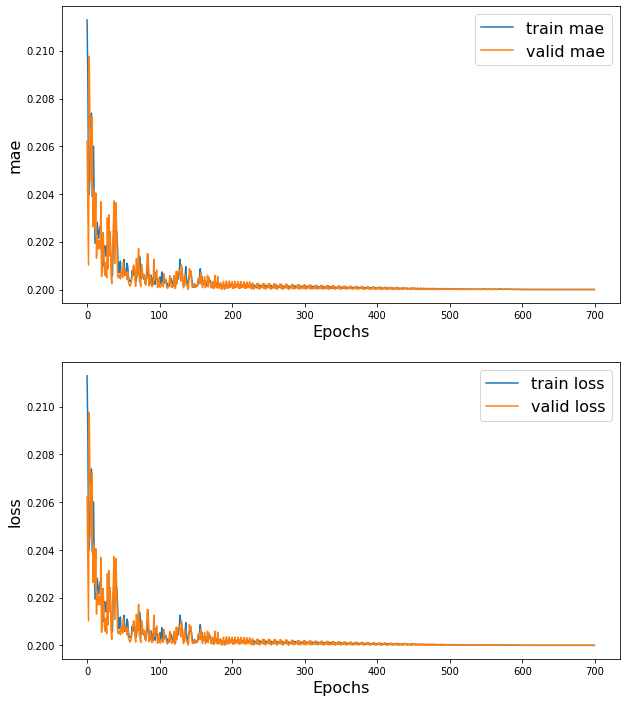

In [90]:
try:
  gnn.train(train_data, valid_data, test_data, epochs=700, lr=3e-3, warm_up=True, load_weights=False, verbose=1, checkpoints=None, save_weights_only=True, workdir=ModulePath)
  gnn.predict_datas(test_data, workdir=ModulePath)    # predict on test datas with labels
except Exception as err:
  print(err)
# y_pred_keras = gnn.predict(datas)                   # predict on new datas without labels